In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data ---
try:
    # Use the correct path for your local setup
    file_path = '../data/cfb_box-scores_2002-2024.csv'
    df = pd.read_csv(file_path)
    print("✅ Successfully loaded the dataset.")
except FileNotFoundError:
    print("❌ Error: Data file not found. Make sure the path is correct.")
    exit()

# CRITICAL STEP 1: Filter to start from the 2004 season where data is complete
df = df[df['season'] >= 2004].copy()
print(f"✅ Dataset filtered to start from season {df['season'].min()}.")

# CRITICAL STEP 2: Remap inconsistent team names to be identical
name_mapping = {
    'UConn': 'Connecticut',
    'UL Monroe': 'Louisiana Monroe',
    'UTEP': 'Texas El Paso',
    'UTSA': 'Texas San Antonio',
    'UAB': 'Alabama Birmingham'
}
df['home'] = df['home'].replace(name_mapping)
df['away'] = df['away'].replace(name_mapping)
print("✅ Team names have been corrected.")

# Debugging: Inspect unique values in 'game_type'
# print("\nUnique values in 'game_type' column:")
# print(df['game_type'].unique())


# --- 2. Feature Engineering (Paper's Methodology) ---
# Calculate the average season stats for every team

regular_season_df = df[df['game_type'] == 'regular'].copy()
bowl_games_df = df[df['game_type'] != 'regular'].copy()

home_stats = regular_season_df.rename(columns={
    'home': 'team', 'score_home': 'points_for', 'score_away': 'points_against',
    'pass_yards_home': 'pass_yards', 'rush_yards_home': 'rush_yards',
    'fum_home': 'fumbles_lost', 'int_home': 'interceptions_thrown'
})
away_stats = regular_season_df.rename(columns={
    'away': 'team', 'score_away': 'points_for', 'score_home': 'points_against',
    'pass_yards_away': 'pass_yards', 'rush_yards_away': 'rush_yards',
    'fum_away': 'fumbles_lost', 'int_away': 'interceptions_thrown'
})

cols_to_keep = ['season', 'team', 'points_for', 'points_against', 'pass_yards', 'rush_yards', 'fumbles_lost', 'interceptions_thrown']
combined_stats = pd.concat([home_stats[cols_to_keep], away_stats[cols_to_keep]])
combined_stats['turnovers'] = combined_stats['fumbles_lost'] + combined_stats['interceptions_thrown']
season_avg_stats = combined_stats.groupby(['season', 'team']).mean().reset_index()

# --- 3. Prepare Final DataFrame for Modeling ---
# Create one row per bowl game with feature differences and targets

modeling_df_list = []
for index, row in bowl_games_df.iterrows():
    season, team1, team2 = row['season'], row['home'], row['away']
    team1_stats = season_avg_stats[(season_avg_stats['season'] == season) & (season_avg_stats['team'] == team1)]
    team2_stats = season_avg_stats[(season_avg_stats['season'] == season) & (season_avg_stats['team'] == team2)]

    if not team1_stats.empty and not team2_stats.empty:
        feature_vector = np.array(team1_stats.drop(columns=['season', 'team'])) - np.array(team2_stats.drop(columns=['season', 'team']))

        game_data = {'season': season}
        feature_names = team1_stats.drop(columns=['season', 'team']).columns
        for i, name in enumerate(feature_names):
            game_data[f'diff_{name}'] = feature_vector[0][i]

        game_data['score_diff'] = row['score_home'] - row['score_away']
        game_data['winner'] = 1 if row['score_home'] > row['score_away'] else 0
        modeling_df_list.append(game_data)

modeling_df = pd.DataFrame(modeling_df_list)
print("✅ Modeling DataFrame created and ready.")


# --- 4. Run Modeling Experiments (Paper's Methodology) ---

seasons = modeling_df['season'].unique()
all_features = [col for col in modeling_df.columns if 'diff_' in col]


✅ Successfully loaded the dataset.
✅ Dataset filtered to start from season 2004.
✅ Team names have been corrected.
✅ Modeling DataFrame created and ready.


In [ ]:
# --- Experiment 1: Baseline Linear Regression ---
print("\n--- Running Baseline Linear Regression with Season-by-Season CV ---")
score_mses, winner_mses = [], []
lr_baseline_accuracy = {} # Store accuracy per season

for test_season in seasons:
    train_df = modeling_df[modeling_df['season'] != test_season]
    test_df = modeling_df[modeling_df['season'] == test_season]
    X_train, y_train_score = train_df[all_features], train_df['score_diff']
    X_test, y_test_score, y_test_winner = test_df[all_features], test_df['score_diff'], test_df['winner']

    lr_score = LinearRegression().fit(X_train, y_train_score)
    y_pred_score = lr_score.predict(X_test)
    score_mses.append(mean_squared_error(y_test_score, y_pred_score))

    predicted_winners = [1 if score > 0 else 0 for score in y_pred_score]
    accuracy = accuracy_score(y_test_winner, predicted_winners)
    winner_mses.append(1 - accuracy)
    lr_baseline_accuracy[test_season] = accuracy

print(f"Average Score Prediction MSE: {np.mean(score_mses):.2f}")
print(f"Average Winner Prediction 'MSE' (Error Rate): {np.mean(winner_mses):.4f}")


--- Running Baseline Linear Regression with Season-by-Season CV ---
Average Score Prediction MSE: 289.72
Average Winner Prediction 'MSE' (Error Rate): 0.4090


In [ ]:
# --- Experiment 2: Linear Regression with Feature Selection ---
print("\n--- Running Feature Selection & Improved Linear Regression ---")
lasso = LassoCV(cv=5, random_state=42, max_iter=10000).fit(modeling_df[all_features], modeling_df['score_diff'])
selected_features = np.array(all_features)[lasso.coef_ != 0]
print(f"Selected features: {list(selected_features)}")

score_mses_fs, winner_mses_fs = [], []
lr_fs_accuracy = {} # Store accuracy per season
for test_season in seasons:
    train_df = modeling_df[modeling_df['season'] != test_season]
    test_df = modeling_df[modeling_df['season'] == test_season]
    X_train, y_train_score = train_df[selected_features], train_df['score_diff']
    X_test, y_test_score, y_test_winner = test_df[selected_features], test_df['score_diff'], test_df['winner']

    lr_score_fs = LinearRegression().fit(X_train, y_train_score)
    y_pred_score_fs = lr_score_fs.predict(X_test)
    score_mses_fs.append(mean_squared_error(y_test_score, y_pred_score_fs))

    predicted_winners_fs = [1 if score > 0 else 0 for score in y_pred_score_fs]
    accuracy = accuracy_score(y_test_winner, predicted_winners_fs)
    winner_mses_fs.append(1 - accuracy)
    lr_fs_accuracy[test_season] = accuracy

print(f"Average Score Prediction MSE (with Feature Selection): {np.mean(score_mses_fs):.2f}")
print(f"Average Winner Prediction 'MSE' (Error Rate): {np.mean(winner_mses_fs):.4f}")



--- Running Feature Selection & Improved Linear Regression ---
Selected features: [np.str_('diff_points_for'), np.str_('diff_points_against'), np.str_('diff_pass_yards'), np.str_('diff_rush_yards'), np.str_('diff_fumbles_lost'), np.str_('diff_interceptions_thrown')]
Average Score Prediction MSE (with Feature Selection): 289.72
Average Winner Prediction 'MSE' (Error Rate): 0.4090


In [ ]:
# --- Experiment 3: Support Vector Machine (SVM) ---
print("\n--- Running SVM with Season-by-Season CV ---")
svr_mses, svc_mses = [], []
svm_accuracy = {} # Store accuracy per season
for test_season in seasons:
    train_df = modeling_df[modeling_df['season'] != test_season]
    test_df = modeling_df[modeling_df['season'] == test_season]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_df[all_features])
    X_test_scaled = scaler.transform(test_df[all_features])

    svr = SVR().fit(X_train_scaled, train_df['score_diff'])
    y_pred_svr = svr.predict(X_test_scaled)
    svr_mses.append(mean_squared_error(test_df['score_diff'], y_pred_svr))

    svc = SVC().fit(X_train_scaled, train_df['winner'])
    y_pred_svc = svc.predict(X_test_scaled)
    accuracy = accuracy_score(test_df['winner'], y_pred_svc)
    svc_mses.append(1 - accuracy)
    svm_accuracy[test_season] = accuracy


print(f"Average SVR Score Prediction MSE: {np.mean(svr_mses):.2f}")
print(f"Average SVC Winner Prediction 'MSE' (Error Rate): {np.mean(svc_mses):.4f}")


--- Running SVM with Season-by-Season CV ---
Average SVR Score Prediction MSE: 297.59
Average SVC Winner Prediction 'MSE' (Error Rate): 0.4217


In [ ]:
# --- Experiment 4: Logistic Regression ---
print("\n--- Running Logistic Regression with Season-by-Season CV ---")
log_mses_baseline, log_mses_fs = [], []
log_reg_baseline_accuracy = {} # Store accuracy per season
log_reg_fs_accuracy = {} # Store accuracy per season
for test_season in seasons:
    train_df = modeling_df[modeling_df['season'] != test_season]
    test_df = modeling_df[modeling_df['season'] == test_season]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_df[all_features])
    X_test_scaled = scaler.transform(test_df[all_features])
    X_train_scaled_fs = scaler.fit_transform(train_df[selected_features])
    X_test_scaled_fs = scaler.transform(test_df[selected_features])

    log_reg_base = LogisticRegression(random_state=42).fit(X_train_scaled, train_df['winner'])
    y_pred_log_base = log_reg_base.predict(X_test_scaled)
    accuracy = accuracy_score(test_df['winner'], y_pred_log_base)
    log_mses_baseline.append(1 - accuracy)
    log_reg_baseline_accuracy[test_season] = accuracy

    log_reg_fs = LogisticRegression(random_state=42).fit(X_train_scaled_fs, train_df['winner'])
    y_pred_log_fs = log_reg_fs.predict(X_test_scaled_fs)
    accuracy = accuracy_score(test_df['winner'], y_pred_log_fs)
    log_mses_fs.append(1 - accuracy)
    log_reg_fs_accuracy[test_season] = accuracy

print(f"Average Baseline Logistic Winner 'MSE' (Error Rate): {np.mean(log_mses_baseline):.4f}")
print(f"Average Reduced Logistic Winner 'MSE' (Error Rate): {np.mean(log_mses_fs):.4f}")


--- Running Logistic Regression with Season-by-Season CV ---
Average Baseline Logistic Winner 'MSE' (Error Rate): 0.4013
Average Reduced Logistic Winner 'MSE' (Error Rate): 0.4013


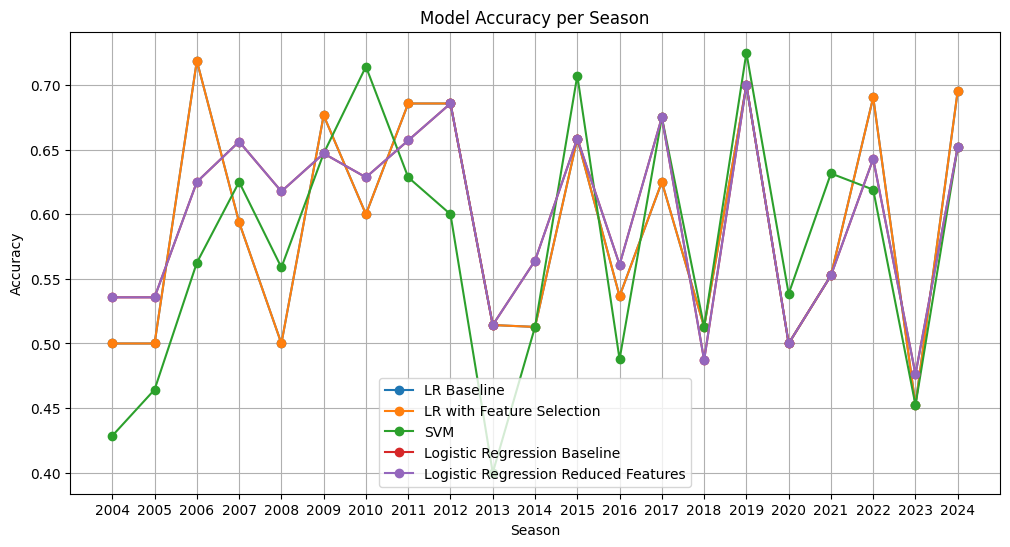

In [ ]:
plt.figure(figsize=(12, 6))

# Plotting the accuracy for each model
plt.plot(list(lr_baseline_accuracy.keys()), list(lr_baseline_accuracy.values()), marker='o', linestyle='-', label='LR Baseline')
plt.plot(list(lr_fs_accuracy.keys()), list(lr_fs_accuracy.values()), marker='o', linestyle='-', label='LR with Feature Selection')
plt.plot(list(svm_accuracy.keys()), list(svm_accuracy.values()), marker='o', linestyle='-', label='SVM')
plt.plot(list(log_reg_baseline_accuracy.keys()), list(log_reg_baseline_accuracy.values()), marker='o', linestyle='-', label='Logistic Regression Baseline')
plt.plot(list(log_reg_fs_accuracy.keys()), list(log_reg_fs_accuracy.values()), marker='o', linestyle='-', label='Logistic Regression Reduced Features')

plt.title('Model Accuracy per Season')
plt.xlabel('Season')
plt.ylabel('Accuracy')
plt.xticks(seasons)
plt.grid(True)
plt.legend()
plt.show()